In [ ]:
# Install LIME
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c0ef559e81605eb47ede3034a4ac853147bc67c73f504f0f418a476b280026a4
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
# Import necessary libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import pandas as pd
from google.colab import drive
import numpy as np
import lime.lime_tabular
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NFRF ML/RF_Data1.csv')

In [ ]:
# Drop the first column (likely index or ID)
df2 = df.drop(df.columns[0], axis=1)

In [ ]:
# Separate features and targets
X = df2.iloc[:, :16].values  # Adjust to your actual feature column range
Y = df2.iloc[:, 16:].values  # Adjust to your actual label column range

In [ ]:
# Function to evaluate classifiers
def evaluate(y_true, y_pred):
    print("Performance Evaluation:")
    print(classification_report(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    auc_score = roc_auc_score(y_true, y_pred, average='macro')
    print("AUC-ROC:", auc_score)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# Define the base classifier
log_reg = LogisticRegression(solver='liblinear', max_iter=1000)

In [ ]:
# Create multi-output classifier
multi_log_reg = MultiOutputClassifier(log_reg)

In [ ]:
# Set parameter grid for logistic regression
param_grid_logreg = {
    'estimator__C': [0.1, 1.0, 10.0],
    'estimator__penalty': ['l1', 'l2']
}

In [ ]:
# Perform grid search
logreg_grid = GridSearchCV(multi_log_reg, param_grid_logreg, cv=3, scoring='accuracy')

In [ ]:
# Fit model
logreg_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000,
                                                                          solver='liblinear')),
             param_grid={'estimator__C': [0.1, 1.0, 10.0],
                         'estimator__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [ ]:
# Predict on test set
logreg_pred = logreg_grid.best_estimator_.predict(X_test)

In [ ]:
# Evaluate performance
print("Performance Evaluation for Logistic Regression Model:")
evaluate(y_test, logreg_pred)

Performance Evaluation for Logistic Regression Model:
Performance Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       282
           1       0.61      0.11      0.18       103
           2       0.60      0.11      0.19       106
           3       0.67      0.23      0.34        88

   micro avg       0.84      0.48      0.61       579
   macro avg       0.69      0.32      0.39       579
weighted avg       0.76      0.48      0.54       579
 samples avg       0.61      0.47      0.50       579

Accuracy: 0.3734015345268542
AUC-ROC: 0.617554009044579


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# LIME Explanation
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=df2.columns[:16],  # adjust if necessary
    class_names=['MAL', 'ENFVR', 'UTI', 'RTI'],  # customize for your dataset
    discretize_continuous=True
)

In [ ]:
# Pick a random test instance
i = np.random.randint(0, X_test.shape[0])

In [ ]:
# Create a predict_proba wrapper for LIME
def predict_proba_wrapper(x):
    probas = logreg_grid.best_estimator_.predict_proba(x)
    return np.column_stack(probas)

/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""
<ipython-input-20-a72cbe2d4398>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


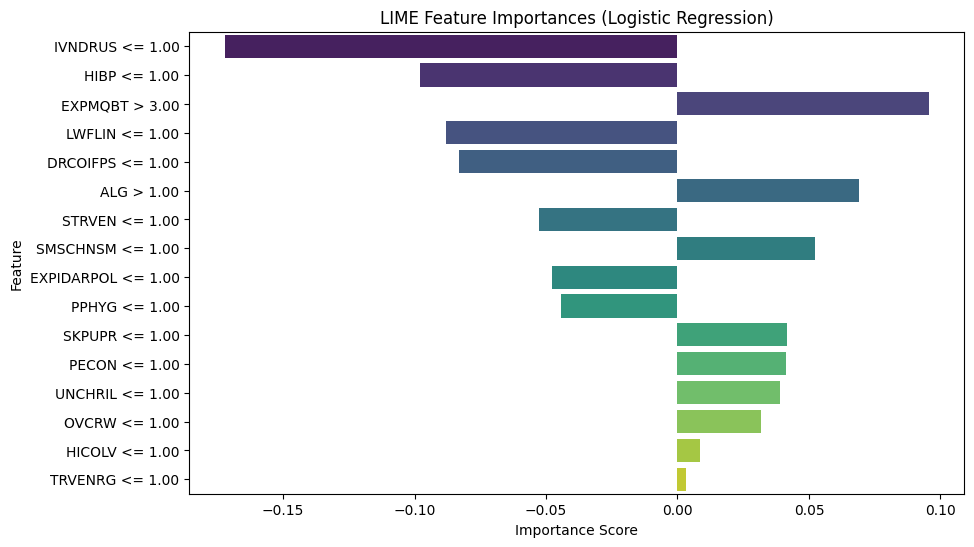

In [ ]:
# Create a predict_proba wrapper for LIME
def predict_proba_wrapper(x):
    # predict_proba returns a list of arrays (one per label)
    probas = logreg_grid.best_estimator_.predict_proba(x)
    try:
        # Check that all are 2D arrays and combine them
        return np.column_stack([p[:, 1] if p.shape[1] > 1 else np.zeros(p.shape[0]) for p in probas])
    except Exception as e:
        print("Error in predict_proba_wrapper:", e)
        return np.zeros((x.shape[0], len(probas)))  # Safe fallback shape

# Generate LIME explanation for one label (e.g., the first one)
try:
    exp = explainer.explain_instance(X_test[i], predict_proba_wrapper, num_features=16)

    # Extract and plot feature importances
    importance_df = pd.DataFrame(exp.as_list(), columns=['Feature', 'Importance'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('LIME Feature Importances (Logistic Regression)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()

except Exception as e:
    print("LIME explanation failed:", e)